In [1]:
import accessvis

In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

path="/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/3hr/pr/gn/latest"
file="pr_3hr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_201001010130-201412312230.nc"

In [3]:
ds=xr.open_dataset(f"{path}/{file}")
ds["pr"][0]

NameError: name 'path' is not defined

In [28]:
def get_interpolated(data, colourmap, blur=2.5):
    lat = data['lat'].values
    lon = data['lon'].values
    newlon = np.linspace(lon[0], lon[-1], 2048)
    newlat = np.linspace(lat[0], lat[-1], 1024)

    interpolated = data.interp(lon=newlon, lat=newlat, method="linear")
    if blur > 0:
        # interpolated_array=interpolated.to_dataarray()
        smoothed = gaussian_filter(interpolated, sigma=blur)
        #smoothed = median_filter(interpolated, size=blur)
    else:
        #No blur
        smoothed = interpolated

    #Convert to image, use raw interpolated data as opacity map for transparency
    rgba = accessvis.array_to_rgba(smoothed, flip=True, colourmap=colourmap, opacitymap=True)
    return rgba

In [83]:
def get_interpolated_au(data, colourmap, blur=2.5):
    lat = data['lat'].values
    lon = data['lon'].values
    newlon = np.linspace(lon[0], lon[-1], 310)
    newlat = np.linspace(lat[0], lat[-1], 155)

    interpolated = data.interp(lon=newlon, lat=newlat, method="linear")
    if blur > 0:
        # interpolated_array=interpolated.to_dataarray()
        smoothed = gaussian_filter(interpolated, sigma=blur)
        #smoothed = median_filter(interpolated, size=blur)
    else:
        #No blur
        smoothed = interpolated
    return smoothed

In [4]:
ds_exa=ds.isel(time=2)["pr"]
colours = get_interpolated(ds_exa, 'turbo')
plt.imshow(colours)

NameError: name 'ds' is not defined

### Video

In [5]:
filename = 'el_test_pr_3hr.mp4'
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))
with lv.video(filename=f'el_test_pr_3hr.mp4',fps=60, quality=3, resolution=(600,600)) as v:
    for i in tqdm(range(len(ds["pr"]))):
        formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
        date.update_widget(text=f"{formatted_date}")
        colours = get_interpolated(ds["pr"][i], 'gist_ncar')
        accessvis.update_earth_values(lv, dataMode=0, data=colours)
        lv.render()

Recording failed:  name 'ds' is not defined


ERROR:aiohttp.server:Error handling request from ::1
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/aiohttp/web_protocol.py", line 510, in _handle_request
    resp = await request_handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/aiohttp/web_app.py", line 569, in _handle
    return await handler(request)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/lavavu/aserver.py", line 107, in handle_get
    lv = _get_viewer(request.app['viewer'])
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/lavavu/aserver.py", line 26, in _get_viewer
    raise(Exception("Viewer not found"))
Exception: Viewer not found


## Accumulate

In [6]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 191.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44775,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 191.00 GiB
Comm: tcp://127.0.0.1:44891,Total threads: 4
Dashboard: /proxy/34689/status,Memory: 31.83 GiB
Nanny: tcp://127.0.0.1:40709,


In [3]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [4]:
from esmvalcore.dataset import Dataset

In [5]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

In [6]:
path="/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/3hr/pr/gn/latest"
file="pr_3hr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_201001010130-201412312230.nc"

ds=xr.open_dataset(os.path.join(path,file))

In [7]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 14608, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 117kB 2010-01-01T01:30:00 ... 2014-12-31...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 234kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    pr         (time, lat, lon) float32 2GB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:30:05Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/3110838a-26ba-4e7b-914b-ef0924f00db3
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [8]:
ds_2010 = ds.sel(time=ds['time'].dt.year == 2010)

In [9]:
ds_2010

<xarray.Dataset> Size: 325MB
Dimensions:    (time: 2920, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2010-01-01T01:30:00 ... 2010-12-31T...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 47kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    pr         (time, lat, lon) float32 325MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:30:05Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/3110838a-26ba-4e7b-914b-ef0924f00db3
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [10]:
ds_2010.isel(time=0).pr+ds_2010.isel(time=1).pr

<xarray.DataArray 'pr' (lat: 145, lon: 192)> Size: 111kB
array([[2.11113957e-06, 2.11113957e-06, 2.11113957e-06, ...,
        2.11113957e-06, 2.11113957e-06, 2.11113957e-06],
       [8.04034244e-07, 7.88065449e-07, 7.76564548e-07, ...,
        8.48339482e-07, 8.36492745e-07, 8.20638547e-07],
       [7.00202008e-07, 7.23885364e-07, 7.41200438e-07, ...,
        6.05535206e-07, 6.37274752e-07, 6.71400244e-07],
       ...,
       [1.23002835e-07, 1.20480223e-07, 1.18911956e-07, ...,
        2.00024331e-07, 1.56405491e-07, 1.36140898e-07],
       [2.57750230e-07, 2.58901736e-07, 2.38812106e-07, ...,
        2.41119494e-07, 2.46504158e-07, 2.51681513e-07],
       [1.99065369e-07, 1.99065369e-07, 1.99065369e-07, ...,
        1.99065369e-07, 1.99065369e-07, 1.99065369e-07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1

In [11]:
ds_2010["pr"][1]+ds_2010["pr"][0]

<xarray.DataArray 'pr' (lat: 145, lon: 192)> Size: 111kB
array([[2.11113957e-06, 2.11113957e-06, 2.11113957e-06, ...,
        2.11113957e-06, 2.11113957e-06, 2.11113957e-06],
       [8.04034244e-07, 7.88065449e-07, 7.76564548e-07, ...,
        8.48339482e-07, 8.36492745e-07, 8.20638547e-07],
       [7.00202008e-07, 7.23885364e-07, 7.41200438e-07, ...,
        6.05535206e-07, 6.37274752e-07, 6.71400244e-07],
       ...,
       [1.23002835e-07, 1.20480223e-07, 1.18911956e-07, ...,
        2.00024331e-07, 1.56405491e-07, 1.36140898e-07],
       [2.57750230e-07, 2.58901736e-07, 2.38812106e-07, ...,
        2.41119494e-07, 2.46504158e-07, 2.51681513e-07],
       [1.99065369e-07, 1.99065369e-07, 1.99065369e-07, ...,
        1.99065369e-07, 1.99065369e-07, 1.99065369e-07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1

In [12]:
# ds_test=ds_2000["pr"][0]
# ds_test+=ds_2000["pr"][1]

In [13]:
ds_1_3 = ds_2010.sel(time=ds_2010['time'].dt.month.isin([1, 2, 3]))
ds_1_3

<xarray.Dataset> Size: 80MB
Dimensions:    (time: 720, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2010-01-01T01:30:00 ... 2010-03-31T2...
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 12kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    pr         (time, lat, lon) float32 80MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:30:05Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/3110838a-26ba-4e7b-914b-ef0924f00db3
    license:                CMIP6 model data produced by CSIRO is licensed un...

100%|██████████| 2920/2920 [22:58<00:00,  2.12it/s]


<IPython.core.display.Javascript object>

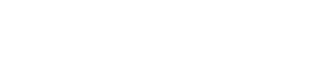

In [36]:
filename = 'acu_pr_day_2000.mp4'
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))
ds=ds_2000
with lv.video(filename=f'acu_pr_day_2000.mp4',fps=60, quality=3, resolution=(600,600)) as v:
    accu=None
    for i in tqdm(range(len(ds["pr"]))):
        if accu is None:
            accu=ds["pr"][i]
        else:
            accu+=ds["pr"][i]
        formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
        date.update_widget(text=f"{formatted_date}")
        colours = get_interpolated(accu, 'gist_ncar')
        accessvis.update_earth_values(lv, dataMode=0, data=colours)
        lv.render()

In [15]:
cam = {'translate': [0.0, 0.0, -17.516432], 
     'rotate': [0.022066, -0.947959, 0.170437, 0.268027], 
     'xyzrotate': [-158.694351, -31.04285, 176.68605], 
     'fov': 45.0, 
     'focus': [-0.014273, -0.037801, 0.001495]}
    # lv.translation(0.0, 0.0, -17.516432),
    # lv.rotation(-158.694351, -31.04285, 176.68605),
   


# lv.camera(cam)
# lv.display()


# filename = 'acu_pr_day_2010_au.mp4'
# lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
# # lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
# # lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
# # lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# lv.camera(cam)
# # date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))
# ds=ds_2010
# with lv.video(filename=filename,fps=60, quality=3, resolution=(600,600)) as v:
#     accu=None
#     for i in tqdm(range(len(ds["pr"]))):
#         if accu is None:
#             accu=ds["pr"][i]
#         else:
#             accu+=ds["pr"][i]
#         formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
#         # date.update_widget(text=f"{formatted_date}")
#         colours = get_interpolated(accu, 'gist_ncar')
#         accessvis.update_earth_values(lv, dataMode=0, data=colours)
#         lv.render()

In [17]:
filename = 'acu_pr_day_2010_1_3_v2.mp4'
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
# lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
# lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
# lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
lv.camera(cam)
# date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))
ds=ds_1_3
with lv.video(filename=filename,fps=60, quality=3, resolution=(600,600)) as v:
    accu=None
    for i in tqdm(range(len(ds["pr"]))):
        if accu is None:
            accu=ds["pr"][i]
        else:
            accu+=ds["pr"][i]
        # formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
        # date.update_widget(text=f"{formatted_date}")
        colours = accessvis.array_to_rgba(accu, flip=True, colourmap='gist_ncar', opacitymap=True, maximum=ds['pr'].data.max(), minimum=ds['pr'].data.min())
        accessvis.update_earth_values(lv, dataMode=0, data=colours)
        lv.render()

100%|██████████| 720/720 [02:31<00:00,  4.76it/s]


<IPython.core.display.Javascript object>

In [88]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.camera(cam)
ds=ds_2010.sum(dim='time')
print(ds['pr'].data.max())
# smoothed = get_interpolated_au(ds['pr'], 'gist_ncar')
# print(smoothed.shape)
colour1 = accessvis.array_to_rgba(ds['pr'], flip=True, colourmap='gist_ncar', opacitymap=True, maximum=ds['pr'].data.max(), minimum=ds['pr'].data.min())
# print(colour1.shape)
accessvis.update_earth_values(lv, dataMode=0, data=colour1)
lv.window(resolution=(600,600))

0.9506178
(155, 310)
(145, 192, 4)


In [29]:
cam = {'translate': [0.0, 0.0, -17.516432], 
     'rotate': [0.022066, -0.947959, 0.170437, 0.268027], 
     'xyzrotate': [-158.694351, -31.04285, 176.68605], 
     'fov': 45.0, 
     'focus': [-0.014273, -0.037801, 0.001495]}
    # lv.translation(0.0, 0.0, -17.516432),
    # lv.rotation(-158.694351, -31.04285, 176.68605),
   


# lv.camera(cam)
# lv.display()

filename = 'acu_pr_day_2010_Jan-Mar.mp4'
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.camera(cam)
# lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
# lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
# lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))
ds=ds_1_3
with lv.video(filename=filename,fps=60, quality=3, resolution=(600,600)) as v:
    accu=None
    for i in tqdm(range(len(ds["pr"]))):
        if accu is None:
            accu=ds["pr"][i]
        else:
            accu+=ds["pr"][i]
        formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
        # date.update_widget(text=f"{formatted_date}")
        colours = get_interpolated(accu, 'gist_ncar')
        accessvis.update_earth_values(lv, dataMode=0, data=colours)
        lv.render()


100%|██████████| 720/720 [04:45<00:00,  2.52it/s]


<IPython.core.display.Javascript object>

In [39]:
def crop(dataset): 
    min_lat = -45
    max_lat = -10
    min_lon = 110
    max_lon = 160

    return dataset.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

def get_interpolated_au(data, colourmap, blur=2.5):
    lat = data['lat'].values
    lon = data['lon'].values
    newlon = np.linspace(lon[0], lon[-1], 310)
    newlat = np.linspace(lat[0], lat[-1], 155)

    interpolated = data.interp(lon=newlon, lat=newlat, method="linear")
    if blur > 0:
        # interpolated_array=interpolated.to_dataarray()
        smoothed = gaussian_filter(interpolated, sigma=blur)
        #smoothed = median_filter(interpolated, size=blur)
    else:
        #No blur
        smoothed = interpolated
    # return smoothed

    rgba = accessvis.array_to_rgba(smoothed, flip=True, colourmap=colourmap, opacitymap=True)
    return rgba

# filename = 'acu_pr_day_2010_Jan-Mar_au.mp4'
# cropbox=((min_lat, min_lon), (max_lat, max_lon))
# lv = accessvis.plot_region(cropbox=cropbox, vertical_exaggeration=vertical_exaggeration)

In [32]:
ds_crop=crop(ds_1_3)
ds_crop

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 720, bnds: 2, lat: 29, lon: 27)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2010-01-01T01:30:00 ... 2010-03-31T2...
  * lat        (lat) float64 232B -45.0 -43.75 -42.5 ... -12.5 -11.25 -10.0
  * lon        (lon) float64 216B 110.6 112.5 114.4 116.2 ... 155.6 157.5 159.4
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 12kB ...
    lat_bnds   (lat, bnds) float64 464B ...
    lon_bnds   (lon, bnds) float64 432B ...
    pr         (time, lat, lon) float32 2MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:30:05Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/3110838a-26ba-4e7b-914b-ef0924f00db3
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [66]:
filename = 'acu_pr_day_2010_Jan-Mar_au.mp4'
min_lat = -45
max_lat = -10
min_lon = 110
max_lon = 160
cropbox=((min_lat, min_lon), (max_lat, max_lon))
lv = accessvis.plot_region(cropbox=cropbox)

ds=crop(ds_1_3)
with lv.video(filename=filename,fps=60, quality=3, resolution=(600,600)) as v:
    accu=None
    for i in tqdm(range(len(ds["pr"]))):
        if accu is None:
            accu=ds["pr"][i]
        else:
            accu+=ds["pr"][i]
        #formatted_date = pd.to_datetime(ds["pr"][i].time.data).strftime('%Y/%m/%d')
        # date.update_widget(text=f"{formatted_date}")
        colours = get_interpolated_au(accu, 'gist_ncar')
        vertical_exaggeration=20
        topo = lv.objects['surface']
        V = topo.data.vertices_copy[0]
        
        offset = 5 * accessvis.MtoLL * vertical_exaggeration # this converts 5m to lat/lon units, including vertical exaggeration
        V[::,::,2] = V[::,::,2] + offset
        
        prsurf = lv.triangles('pr', vertices=V, cullface=True, texture="blank.png", lit=False, alpha=0.6)
        prsurf.texture(colours)
        lv.render()

(6000, 8100) (17400, 20400)
(6000, 8100) (17400, 20400)


  0%|          | 1/720 [00:03<47:00,  3.92s/it]

Object exists: pr


  0%|          | 2/720 [00:05<30:56,  2.59s/it]

Object exists: pr


  0%|          | 3/720 [00:07<25:36,  2.14s/it]

Object exists: pr


  1%|          | 4/720 [00:08<23:06,  1.94s/it]

Object exists: pr


  1%|          | 5/720 [00:10<22:01,  1.85s/it]

Object exists: pr


  1%|          | 6/720 [00:12<21:09,  1.78s/it]

Object exists: pr


  1%|          | 7/720 [00:13<20:28,  1.72s/it]

Object exists: pr


  1%|          | 8/720 [00:15<20:11,  1.70s/it]

Object exists: pr


  1%|▏         | 9/720 [00:17<20:04,  1.69s/it]

Object exists: pr


  1%|▏         | 10/720 [00:18<20:33,  1.74s/it]

Object exists: pr


  2%|▏         | 11/720 [00:20<20:06,  1.70s/it]

Object exists: pr


  2%|▏         | 12/720 [00:22<19:55,  1.69s/it]

Object exists: pr


  2%|▏         | 13/720 [00:23<19:48,  1.68s/it]

Object exists: pr


  2%|▏         | 14/720 [00:25<19:34,  1.66s/it]

Object exists: pr


  2%|▏         | 15/720 [00:27<19:22,  1.65s/it]

Object exists: pr


  2%|▏         | 16/720 [00:28<19:19,  1.65s/it]

Object exists: pr


  2%|▏         | 17/720 [00:30<19:27,  1.66s/it]

Object exists: pr


  2%|▎         | 18/720 [00:32<19:13,  1.64s/it]

Object exists: pr


  3%|▎         | 19/720 [00:33<19:13,  1.64s/it]

Object exists: pr


  3%|▎         | 20/720 [00:35<19:05,  1.64s/it]

Object exists: pr


  3%|▎         | 21/720 [00:36<19:01,  1.63s/it]

Object exists: pr


  3%|▎         | 22/720 [00:38<18:55,  1.63s/it]

Object exists: pr


  3%|▎         | 23/720 [00:40<18:50,  1.62s/it]

Object exists: pr


  3%|▎         | 24/720 [00:41<18:43,  1.61s/it]

Object exists: pr


  3%|▎         | 25/720 [00:43<18:27,  1.59s/it]

Object exists: pr


  4%|▎         | 26/720 [00:44<17:52,  1.55s/it]

Object exists: pr


  4%|▍         | 27/720 [00:46<17:19,  1.50s/it]

Object exists: pr


  4%|▍         | 28/720 [00:47<16:56,  1.47s/it]

Object exists: pr


  4%|▍         | 29/720 [00:48<16:42,  1.45s/it]

Object exists: pr


  4%|▍         | 30/720 [00:50<16:30,  1.44s/it]

Object exists: pr


  4%|▍         | 31/720 [00:51<16:20,  1.42s/it]

Object exists: pr


  4%|▍         | 32/720 [00:53<16:18,  1.42s/it]

Object exists: pr


  5%|▍         | 33/720 [00:54<16:12,  1.42s/it]

Object exists: pr


  5%|▍         | 34/720 [00:55<16:18,  1.43s/it]

Object exists: pr


  5%|▍         | 35/720 [00:57<16:21,  1.43s/it]

Object exists: pr


  5%|▌         | 36/720 [00:58<16:14,  1.42s/it]

Object exists: pr


  5%|▌         | 37/720 [01:00<16:13,  1.42s/it]

Object exists: pr


  5%|▌         | 38/720 [01:01<16:09,  1.42s/it]

Object exists: pr


  5%|▌         | 39/720 [01:03<16:13,  1.43s/it]

Object exists: pr


  6%|▌         | 40/720 [01:04<16:07,  1.42s/it]

Object exists: pr


  6%|▌         | 41/720 [01:05<16:01,  1.42s/it]

Object exists: pr


  6%|▌         | 42/720 [01:07<16:07,  1.43s/it]

Object exists: pr


  6%|▌         | 43/720 [01:08<16:08,  1.43s/it]

Object exists: pr


  6%|▌         | 44/720 [01:10<16:08,  1.43s/it]

Object exists: pr


  6%|▋         | 45/720 [01:11<16:05,  1.43s/it]

Object exists: pr


  6%|▋         | 46/720 [01:13<15:56,  1.42s/it]

Object exists: pr


  7%|▋         | 47/720 [01:14<15:49,  1.41s/it]

Object exists: pr


  7%|▋         | 48/720 [01:15<15:46,  1.41s/it]

Object exists: pr


  7%|▋         | 49/720 [01:17<15:43,  1.41s/it]

Object exists: pr


  7%|▋         | 50/720 [01:18<15:41,  1.41s/it]

Object exists: pr


  7%|▋         | 51/720 [01:20<15:38,  1.40s/it]

Object exists: pr


  7%|▋         | 52/720 [01:21<15:34,  1.40s/it]

Object exists: pr


  7%|▋         | 53/720 [01:22<15:33,  1.40s/it]

Object exists: pr


  8%|▊         | 54/720 [01:24<15:30,  1.40s/it]

Object exists: pr


  8%|▊         | 55/720 [01:25<15:46,  1.42s/it]

Object exists: pr


  8%|▊         | 56/720 [01:27<15:39,  1.41s/it]

Object exists: pr


  8%|▊         | 57/720 [01:28<15:33,  1.41s/it]

Object exists: pr


  8%|▊         | 58/720 [01:30<16:04,  1.46s/it]

Object exists: pr


  8%|▊         | 59/720 [01:31<15:54,  1.44s/it]

Object exists: pr


  8%|▊         | 60/720 [01:32<15:47,  1.44s/it]

Object exists: pr


  8%|▊         | 61/720 [01:34<15:41,  1.43s/it]

Object exists: pr


  9%|▊         | 62/720 [01:35<15:43,  1.43s/it]

Object exists: pr


  9%|▉         | 63/720 [01:37<15:44,  1.44s/it]

Object exists: pr


  9%|▉         | 64/720 [01:38<15:37,  1.43s/it]

Object exists: pr


  9%|▉         | 65/720 [01:40<16:05,  1.47s/it]

Object exists: pr


  9%|▉         | 66/720 [01:41<16:00,  1.47s/it]

Object exists: pr


  9%|▉         | 67/720 [01:43<15:45,  1.45s/it]

Object exists: pr


  9%|▉         | 68/720 [01:44<15:34,  1.43s/it]

Object exists: pr


 10%|▉         | 69/720 [01:45<15:29,  1.43s/it]

Object exists: pr


 10%|▉         | 70/720 [01:47<15:37,  1.44s/it]

Object exists: pr


 10%|▉         | 71/720 [01:48<15:31,  1.43s/it]

Object exists: pr


 10%|█         | 72/720 [01:50<15:23,  1.42s/it]

Object exists: pr


 10%|█         | 73/720 [01:51<15:18,  1.42s/it]

Object exists: pr


 10%|█         | 74/720 [01:52<15:11,  1.41s/it]

Object exists: pr


 10%|█         | 75/720 [01:54<15:08,  1.41s/it]

Object exists: pr


 11%|█         | 76/720 [01:55<15:05,  1.41s/it]

Object exists: pr


 11%|█         | 77/720 [01:57<15:26,  1.44s/it]

Object exists: pr


 11%|█         | 78/720 [01:58<15:19,  1.43s/it]

Object exists: pr


 11%|█         | 79/720 [02:00<15:10,  1.42s/it]

Object exists: pr


 11%|█         | 80/720 [02:01<15:05,  1.42s/it]

Object exists: pr


 11%|█▏        | 81/720 [02:02<15:05,  1.42s/it]

Object exists: pr


 11%|█▏        | 82/720 [02:04<15:01,  1.41s/it]

Object exists: pr


 12%|█▏        | 83/720 [02:05<14:56,  1.41s/it]

Object exists: pr


 12%|█▏        | 84/720 [02:07<14:55,  1.41s/it]

Object exists: pr


 12%|█▏        | 85/720 [02:08<14:54,  1.41s/it]

Object exists: pr


 12%|█▏        | 86/720 [02:09<14:54,  1.41s/it]

Object exists: pr


 12%|█▏        | 87/720 [02:11<15:01,  1.42s/it]

Object exists: pr


 12%|█▏        | 88/720 [02:12<15:02,  1.43s/it]

Object exists: pr


 12%|█▏        | 89/720 [02:14<14:57,  1.42s/it]

Object exists: pr


 12%|█▎        | 90/720 [02:15<14:54,  1.42s/it]

Object exists: pr


 13%|█▎        | 91/720 [02:17<14:54,  1.42s/it]

Object exists: pr


 13%|█▎        | 92/720 [02:18<15:02,  1.44s/it]

Object exists: pr


 13%|█▎        | 93/720 [02:20<14:56,  1.43s/it]

Object exists: pr


 13%|█▎        | 94/720 [02:21<14:53,  1.43s/it]

Object exists: pr


 13%|█▎        | 95/720 [02:22<14:56,  1.43s/it]

Object exists: pr


 13%|█▎        | 96/720 [02:24<14:56,  1.44s/it]

Object exists: pr


 13%|█▎        | 97/720 [02:25<14:50,  1.43s/it]

Object exists: pr


 14%|█▎        | 98/720 [02:27<14:43,  1.42s/it]

Object exists: pr


 14%|█▍        | 99/720 [02:28<14:58,  1.45s/it]

Object exists: pr


 14%|█▍        | 100/720 [02:30<14:47,  1.43s/it]

Object exists: pr


 14%|█▍        | 101/720 [02:31<15:07,  1.47s/it]

Object exists: pr


 14%|█▍        | 102/720 [02:32<14:52,  1.44s/it]

Object exists: pr


 14%|█▍        | 103/720 [02:34<14:43,  1.43s/it]

Object exists: pr


 14%|█▍        | 104/720 [02:35<14:34,  1.42s/it]

Object exists: pr


 15%|█▍        | 105/720 [02:37<14:28,  1.41s/it]

Object exists: pr


 15%|█▍        | 106/720 [02:38<14:23,  1.41s/it]

Object exists: pr


 15%|█▍        | 107/720 [02:39<14:24,  1.41s/it]

Object exists: pr


 15%|█▌        | 108/720 [02:41<14:54,  1.46s/it]

Object exists: pr


 15%|█▌        | 109/720 [02:42<14:39,  1.44s/it]

Object exists: pr


 15%|█▌        | 110/720 [02:44<14:31,  1.43s/it]

Object exists: pr


 15%|█▌        | 111/720 [02:45<14:24,  1.42s/it]

Object exists: pr


 16%|█▌        | 112/720 [02:47<14:22,  1.42s/it]

Object exists: pr


 16%|█▌        | 113/720 [02:48<14:27,  1.43s/it]

Object exists: pr


 16%|█▌        | 114/720 [02:50<14:29,  1.43s/it]

Object exists: pr


 16%|█▌        | 115/720 [02:51<14:21,  1.42s/it]

Object exists: pr


 16%|█▌        | 116/720 [02:52<14:23,  1.43s/it]

Object exists: pr


 16%|█▋        | 117/720 [02:54<14:30,  1.44s/it]

Object exists: pr


 16%|█▋        | 118/720 [02:55<14:35,  1.45s/it]

Object exists: pr


 17%|█▋        | 119/720 [02:57<14:26,  1.44s/it]

Object exists: pr


 17%|█▋        | 120/720 [02:58<14:19,  1.43s/it]

Object exists: pr


 17%|█▋        | 121/720 [03:00<14:20,  1.44s/it]

Object exists: pr


 17%|█▋        | 122/720 [03:01<14:18,  1.44s/it]

Object exists: pr


 17%|█▋        | 123/720 [03:03<14:17,  1.44s/it]

Object exists: pr


 17%|█▋        | 124/720 [03:04<14:17,  1.44s/it]

Object exists: pr


 17%|█▋        | 125/720 [03:05<14:11,  1.43s/it]

Object exists: pr


 18%|█▊        | 126/720 [03:07<14:04,  1.42s/it]

Object exists: pr


 18%|█▊        | 127/720 [03:08<13:57,  1.41s/it]

Object exists: pr


 18%|█▊        | 128/720 [03:10<13:54,  1.41s/it]

Object exists: pr


 18%|█▊        | 129/720 [03:11<13:49,  1.40s/it]

Object exists: pr


 18%|█▊        | 130/720 [03:12<13:49,  1.41s/it]

Object exists: pr


 18%|█▊        | 131/720 [03:14<13:46,  1.40s/it]

Object exists: pr


 18%|█▊        | 132/720 [03:15<13:51,  1.41s/it]

Object exists: pr


 18%|█▊        | 133/720 [03:17<13:50,  1.42s/it]

Object exists: pr


 19%|█▊        | 134/720 [03:18<13:46,  1.41s/it]

Object exists: pr


 19%|█▉        | 135/720 [03:19<13:46,  1.41s/it]

Object exists: pr


 19%|█▉        | 136/720 [03:21<13:41,  1.41s/it]

Object exists: pr


 19%|█▉        | 137/720 [03:22<13:39,  1.41s/it]

Object exists: pr


 19%|█▉        | 138/720 [03:24<13:40,  1.41s/it]

Object exists: pr


 19%|█▉        | 139/720 [03:25<13:36,  1.41s/it]

Object exists: pr


 19%|█▉        | 140/720 [03:26<13:41,  1.42s/it]

Object exists: pr


 20%|█▉        | 141/720 [03:28<13:45,  1.43s/it]

Object exists: pr


 20%|█▉        | 142/720 [03:29<13:38,  1.42s/it]

Object exists: pr


 20%|█▉        | 143/720 [03:31<13:41,  1.42s/it]

Object exists: pr


 20%|██        | 144/720 [03:32<13:37,  1.42s/it]

Object exists: pr


 20%|██        | 145/720 [03:34<13:37,  1.42s/it]

Object exists: pr


 20%|██        | 146/720 [03:35<13:37,  1.42s/it]

Object exists: pr


 20%|██        | 147/720 [03:36<13:32,  1.42s/it]

Object exists: pr


 21%|██        | 148/720 [03:38<13:32,  1.42s/it]

Object exists: pr


 21%|██        | 149/720 [03:39<13:33,  1.43s/it]

Object exists: pr


 21%|██        | 150/720 [03:41<13:34,  1.43s/it]

Object exists: pr


 21%|██        | 151/720 [03:42<13:29,  1.42s/it]

Object exists: pr


 21%|██        | 152/720 [03:44<13:25,  1.42s/it]

Object exists: pr


 21%|██▏       | 153/720 [03:45<13:20,  1.41s/it]

Object exists: pr


 21%|██▏       | 154/720 [03:46<13:17,  1.41s/it]

Object exists: pr


 22%|██▏       | 155/720 [03:48<13:13,  1.40s/it]

Object exists: pr


 22%|██▏       | 156/720 [03:49<13:09,  1.40s/it]

Object exists: pr


 22%|██▏       | 157/720 [03:51<13:07,  1.40s/it]

Object exists: pr


 22%|██▏       | 158/720 [03:52<13:23,  1.43s/it]

Object exists: pr


 22%|██▏       | 159/720 [03:53<13:17,  1.42s/it]

Object exists: pr


 22%|██▏       | 160/720 [03:55<13:17,  1.42s/it]

Object exists: pr


 22%|██▏       | 161/720 [03:56<13:12,  1.42s/it]

Object exists: pr


 22%|██▎       | 162/720 [03:58<13:06,  1.41s/it]

Object exists: pr


 23%|██▎       | 163/720 [03:59<13:02,  1.41s/it]

Object exists: pr


 23%|██▎       | 164/720 [04:00<13:00,  1.40s/it]

Object exists: pr


 23%|██▎       | 165/720 [04:02<13:02,  1.41s/it]

Object exists: pr


 23%|██▎       | 166/720 [04:03<13:05,  1.42s/it]

Object exists: pr


 23%|██▎       | 167/720 [04:05<13:10,  1.43s/it]

Object exists: pr


 23%|██▎       | 168/720 [04:06<13:04,  1.42s/it]

Object exists: pr


 23%|██▎       | 169/720 [04:08<13:19,  1.45s/it]

Object exists: pr


 24%|██▎       | 170/720 [04:09<13:10,  1.44s/it]

Object exists: pr


 24%|██▍       | 171/720 [04:11<13:10,  1.44s/it]

Object exists: pr


 24%|██▍       | 172/720 [04:12<13:03,  1.43s/it]

Object exists: pr


 24%|██▍       | 173/720 [04:13<13:04,  1.43s/it]

Object exists: pr


 24%|██▍       | 174/720 [04:15<13:07,  1.44s/it]

Object exists: pr


 24%|██▍       | 175/720 [04:16<13:04,  1.44s/it]

Object exists: pr


 24%|██▍       | 176/720 [04:18<13:04,  1.44s/it]

Object exists: pr


 25%|██▍       | 177/720 [04:19<12:58,  1.43s/it]

Object exists: pr


 25%|██▍       | 178/720 [04:21<12:51,  1.42s/it]

Object exists: pr


 25%|██▍       | 179/720 [04:22<12:45,  1.41s/it]

Object exists: pr


 25%|██▌       | 180/720 [04:23<12:54,  1.43s/it]

Object exists: pr


 25%|██▌       | 181/720 [04:25<12:48,  1.43s/it]

Object exists: pr


 25%|██▌       | 182/720 [04:26<12:42,  1.42s/it]

Object exists: pr


 25%|██▌       | 183/720 [04:28<12:37,  1.41s/it]

Object exists: pr


 26%|██▌       | 184/720 [04:29<12:34,  1.41s/it]

Object exists: pr


 26%|██▌       | 185/720 [04:30<12:33,  1.41s/it]

Object exists: pr


 26%|██▌       | 186/720 [04:32<12:37,  1.42s/it]

Object exists: pr


 26%|██▌       | 187/720 [04:33<12:46,  1.44s/it]

Object exists: pr


 26%|██▌       | 188/720 [04:35<12:38,  1.43s/it]

Object exists: pr


 26%|██▋       | 189/720 [04:36<12:31,  1.42s/it]

Object exists: pr


 26%|██▋       | 190/720 [04:38<12:30,  1.42s/it]

Object exists: pr


 27%|██▋       | 191/720 [04:39<12:31,  1.42s/it]

Object exists: pr


 27%|██▋       | 192/720 [04:40<12:35,  1.43s/it]

Object exists: pr


 27%|██▋       | 193/720 [04:42<12:38,  1.44s/it]

Object exists: pr


 27%|██▋       | 194/720 [04:43<12:35,  1.44s/it]

Object exists: pr


 27%|██▋       | 195/720 [04:45<12:32,  1.43s/it]

Object exists: pr


 27%|██▋       | 196/720 [04:46<12:37,  1.45s/it]

Object exists: pr


 27%|██▋       | 197/720 [04:48<12:28,  1.43s/it]

Object exists: pr


 28%|██▊       | 198/720 [04:49<12:24,  1.43s/it]

Object exists: pr


 28%|██▊       | 199/720 [04:50<12:26,  1.43s/it]

Object exists: pr


 28%|██▊       | 200/720 [04:52<12:26,  1.44s/it]

Object exists: pr


 28%|██▊       | 201/720 [04:53<12:22,  1.43s/it]

Object exists: pr


 28%|██▊       | 202/720 [04:55<12:15,  1.42s/it]

Object exists: pr


 28%|██▊       | 203/720 [04:56<12:11,  1.42s/it]

Object exists: pr


 28%|██▊       | 204/720 [04:58<12:08,  1.41s/it]

Object exists: pr


 28%|██▊       | 205/720 [04:59<12:07,  1.41s/it]

Object exists: pr


 29%|██▊       | 206/720 [05:00<12:06,  1.41s/it]

Object exists: pr


 29%|██▉       | 207/720 [05:02<12:02,  1.41s/it]

Object exists: pr


 29%|██▉       | 208/720 [05:03<12:15,  1.44s/it]

Object exists: pr


 29%|██▉       | 209/720 [05:05<12:09,  1.43s/it]

Object exists: pr


 29%|██▉       | 210/720 [05:06<12:03,  1.42s/it]

Object exists: pr


 29%|██▉       | 211/720 [05:08<12:02,  1.42s/it]

Object exists: pr


 29%|██▉       | 212/720 [05:09<12:00,  1.42s/it]

Object exists: pr


 30%|██▉       | 213/720 [05:10<11:58,  1.42s/it]

Object exists: pr


 30%|██▉       | 214/720 [05:12<11:55,  1.41s/it]

Object exists: pr


 30%|██▉       | 215/720 [05:13<11:51,  1.41s/it]

Object exists: pr


 30%|███       | 216/720 [05:15<11:51,  1.41s/it]

Object exists: pr


 30%|███       | 217/720 [05:16<11:55,  1.42s/it]

Object exists: pr


 30%|███       | 218/720 [05:17<11:57,  1.43s/it]

Object exists: pr


 30%|███       | 219/720 [05:19<11:54,  1.43s/it]

Object exists: pr


 31%|███       | 220/720 [05:20<12:07,  1.46s/it]

Object exists: pr


 31%|███       | 221/720 [05:22<11:59,  1.44s/it]

Object exists: pr


 31%|███       | 222/720 [05:23<12:02,  1.45s/it]

Object exists: pr


 31%|███       | 223/720 [05:25<11:54,  1.44s/it]

Object exists: pr


 31%|███       | 224/720 [05:26<11:48,  1.43s/it]

Object exists: pr


 31%|███▏      | 225/720 [05:28<11:49,  1.43s/it]

Object exists: pr


 31%|███▏      | 226/720 [05:29<11:49,  1.44s/it]

Object exists: pr


 32%|███▏      | 227/720 [05:30<11:45,  1.43s/it]

Object exists: pr


 32%|███▏      | 228/720 [05:32<11:38,  1.42s/it]

Object exists: pr


 32%|███▏      | 229/720 [05:33<11:34,  1.41s/it]

Object exists: pr


 32%|███▏      | 230/720 [05:35<11:31,  1.41s/it]

Object exists: pr


 32%|███▏      | 231/720 [05:36<11:35,  1.42s/it]

Object exists: pr


 32%|███▏      | 232/720 [05:37<11:29,  1.41s/it]

Object exists: pr


 32%|███▏      | 233/720 [05:39<11:27,  1.41s/it]

Object exists: pr


 32%|███▎      | 234/720 [05:40<11:25,  1.41s/it]

Object exists: pr


 33%|███▎      | 235/720 [05:42<11:28,  1.42s/it]

Object exists: pr


 33%|███▎      | 236/720 [05:43<11:28,  1.42s/it]

Object exists: pr


 33%|███▎      | 237/720 [05:45<11:24,  1.42s/it]

Object exists: pr


 33%|███▎      | 238/720 [05:46<11:21,  1.41s/it]

Object exists: pr


 33%|███▎      | 239/720 [05:47<11:19,  1.41s/it]

Object exists: pr


 33%|███▎      | 240/720 [05:49<11:15,  1.41s/it]

Object exists: pr


 33%|███▎      | 241/720 [05:50<11:13,  1.41s/it]

Object exists: pr


 34%|███▎      | 242/720 [05:52<11:19,  1.42s/it]

Object exists: pr


 34%|███▍      | 243/720 [05:53<11:24,  1.44s/it]

Object exists: pr


 34%|███▍      | 244/720 [05:55<11:26,  1.44s/it]

Object exists: pr


 34%|███▍      | 245/720 [05:56<11:24,  1.44s/it]

Object exists: pr


 34%|███▍      | 246/720 [05:57<11:30,  1.46s/it]

Object exists: pr


 34%|███▍      | 247/720 [05:59<11:33,  1.47s/it]

Object exists: pr


 34%|███▍      | 248/720 [06:00<11:33,  1.47s/it]

Object exists: pr


 35%|███▍      | 249/720 [06:02<11:28,  1.46s/it]

Object exists: pr


 35%|███▍      | 250/720 [06:03<11:31,  1.47s/it]

Object exists: pr


 35%|███▍      | 251/720 [06:05<11:31,  1.48s/it]

Object exists: pr


 35%|███▌      | 252/720 [06:06<11:24,  1.46s/it]

Object exists: pr


 35%|███▌      | 253/720 [06:08<11:17,  1.45s/it]

Object exists: pr


 35%|███▌      | 254/720 [06:09<11:11,  1.44s/it]

Object exists: pr


 35%|███▌      | 255/720 [06:11<11:07,  1.43s/it]

Object exists: pr


 36%|███▌      | 256/720 [06:12<11:04,  1.43s/it]

Object exists: pr


 36%|███▌      | 257/720 [06:13<11:03,  1.43s/it]

Object exists: pr


 36%|███▌      | 258/720 [06:15<11:01,  1.43s/it]

Object exists: pr


 36%|███▌      | 259/720 [06:16<10:57,  1.43s/it]

Object exists: pr


 36%|███▌      | 260/720 [06:18<11:03,  1.44s/it]

Object exists: pr


 36%|███▋      | 261/720 [06:19<11:02,  1.44s/it]

Object exists: pr


 36%|███▋      | 262/720 [06:21<10:59,  1.44s/it]

Object exists: pr


 37%|███▋      | 263/720 [06:22<10:56,  1.44s/it]

Object exists: pr


 37%|███▋      | 264/720 [06:23<10:52,  1.43s/it]

Object exists: pr


 37%|███▋      | 265/720 [06:25<10:50,  1.43s/it]

Object exists: pr


 37%|███▋      | 266/720 [06:26<10:48,  1.43s/it]

Object exists: pr


 37%|███▋      | 267/720 [06:28<10:50,  1.44s/it]

Object exists: pr


 37%|███▋      | 268/720 [06:29<10:52,  1.44s/it]

Object exists: pr


 37%|███▋      | 269/720 [06:31<10:50,  1.44s/it]

Object exists: pr


 38%|███▊      | 270/720 [06:32<10:46,  1.44s/it]

Object exists: pr


 38%|███▊      | 271/720 [06:34<11:00,  1.47s/it]

Object exists: pr


 38%|███▊      | 272/720 [06:35<10:59,  1.47s/it]

Object exists: pr


 38%|███▊      | 273/720 [06:37<10:53,  1.46s/it]

Object exists: pr


 38%|███▊      | 274/720 [06:38<10:46,  1.45s/it]

Object exists: pr


 38%|███▊      | 275/720 [06:39<10:51,  1.46s/it]

Object exists: pr


 38%|███▊      | 276/720 [06:41<10:48,  1.46s/it]

Object exists: pr


 38%|███▊      | 277/720 [06:42<10:49,  1.47s/it]

Object exists: pr


 39%|███▊      | 278/720 [06:44<10:54,  1.48s/it]

Object exists: pr


 39%|███▉      | 279/720 [06:45<10:46,  1.47s/it]

Object exists: pr


 39%|███▉      | 280/720 [06:47<10:38,  1.45s/it]

Object exists: pr


 39%|███▉      | 281/720 [06:48<10:34,  1.45s/it]

Object exists: pr


 39%|███▉      | 282/720 [06:50<10:45,  1.47s/it]

Object exists: pr


 39%|███▉      | 283/720 [06:51<10:36,  1.46s/it]

Object exists: pr


 39%|███▉      | 284/720 [06:53<10:29,  1.44s/it]

Object exists: pr


 40%|███▉      | 285/720 [06:54<10:27,  1.44s/it]

Object exists: pr


 40%|███▉      | 286/720 [06:55<10:25,  1.44s/it]

Object exists: pr


 40%|███▉      | 287/720 [06:57<10:24,  1.44s/it]

Object exists: pr


 40%|████      | 288/720 [06:58<10:21,  1.44s/it]

Object exists: pr


 40%|████      | 289/720 [07:00<10:19,  1.44s/it]

Object exists: pr


 40%|████      | 290/720 [07:01<10:16,  1.43s/it]

Object exists: pr


 40%|████      | 291/720 [07:03<10:13,  1.43s/it]

Object exists: pr


 41%|████      | 292/720 [07:04<10:12,  1.43s/it]

Object exists: pr


 41%|████      | 293/720 [07:05<10:13,  1.44s/it]

Object exists: pr


 41%|████      | 294/720 [07:07<10:15,  1.45s/it]

Object exists: pr


 41%|████      | 295/720 [07:08<10:14,  1.45s/it]

Object exists: pr


 41%|████      | 296/720 [07:10<10:14,  1.45s/it]

Object exists: pr


 41%|████▏     | 297/720 [07:11<10:16,  1.46s/it]

Object exists: pr


 41%|████▏     | 298/720 [07:13<10:11,  1.45s/it]

Object exists: pr


 42%|████▏     | 299/720 [07:14<10:06,  1.44s/it]

Object exists: pr


 42%|████▏     | 300/720 [07:16<10:10,  1.45s/it]

Object exists: pr


 42%|████▏     | 301/720 [07:17<10:10,  1.46s/it]

Object exists: pr


 42%|████▏     | 302/720 [07:19<10:04,  1.45s/it]

Object exists: pr


 42%|████▏     | 303/720 [07:20<09:58,  1.44s/it]

Object exists: pr


 42%|████▏     | 304/720 [07:21<09:55,  1.43s/it]

Object exists: pr


 42%|████▏     | 305/720 [07:23<09:52,  1.43s/it]

Object exists: pr


 42%|████▎     | 306/720 [07:24<09:51,  1.43s/it]

Object exists: pr


 43%|████▎     | 307/720 [07:26<09:49,  1.43s/it]

Object exists: pr


 43%|████▎     | 308/720 [07:27<09:46,  1.42s/it]

Object exists: pr


 43%|████▎     | 309/720 [07:28<09:43,  1.42s/it]

Object exists: pr


 43%|████▎     | 310/720 [07:30<09:44,  1.43s/it]

Object exists: pr


 43%|████▎     | 311/720 [07:31<09:59,  1.47s/it]

Object exists: pr


 43%|████▎     | 312/720 [07:33<09:55,  1.46s/it]

Object exists: pr


 43%|████▎     | 313/720 [07:34<09:51,  1.45s/it]

Object exists: pr


 44%|████▎     | 314/720 [07:36<09:45,  1.44s/it]

Object exists: pr


 44%|████▍     | 315/720 [07:37<09:40,  1.43s/it]

Object exists: pr


 44%|████▍     | 316/720 [07:39<09:37,  1.43s/it]

Object exists: pr


 44%|████▍     | 317/720 [07:40<09:38,  1.43s/it]

Object exists: pr


 44%|████▍     | 318/720 [07:42<09:41,  1.45s/it]

Object exists: pr


 44%|████▍     | 319/720 [07:43<09:37,  1.44s/it]

Object exists: pr


 44%|████▍     | 320/720 [07:44<09:36,  1.44s/it]

Object exists: pr


 45%|████▍     | 321/720 [07:46<09:37,  1.45s/it]

Object exists: pr


 45%|████▍     | 322/720 [07:47<09:41,  1.46s/it]

Object exists: pr


 45%|████▍     | 323/720 [07:49<09:34,  1.45s/it]

Object exists: pr


 45%|████▌     | 324/720 [07:50<09:31,  1.44s/it]

Object exists: pr


 45%|████▌     | 325/720 [07:52<09:45,  1.48s/it]

Object exists: pr


 45%|████▌     | 326/720 [07:53<09:41,  1.48s/it]

Object exists: pr


 45%|████▌     | 327/720 [07:55<09:34,  1.46s/it]

Object exists: pr


 46%|████▌     | 328/720 [07:56<09:29,  1.45s/it]

Object exists: pr


 46%|████▌     | 329/720 [07:58<09:35,  1.47s/it]

Object exists: pr


 46%|████▌     | 330/720 [07:59<09:27,  1.45s/it]

Object exists: pr


 46%|████▌     | 331/720 [08:00<09:21,  1.44s/it]

Object exists: pr


 46%|████▌     | 332/720 [08:02<09:18,  1.44s/it]

Object exists: pr


 46%|████▋     | 333/720 [08:03<09:15,  1.43s/it]

Object exists: pr


 46%|████▋     | 334/720 [08:05<09:14,  1.44s/it]

Object exists: pr


 47%|████▋     | 335/720 [08:06<09:10,  1.43s/it]

Object exists: pr


 47%|████▋     | 336/720 [08:08<09:17,  1.45s/it]

Object exists: pr


 47%|████▋     | 337/720 [08:09<09:12,  1.44s/it]

Object exists: pr


 47%|████▋     | 338/720 [08:10<09:08,  1.43s/it]

Object exists: pr


 47%|████▋     | 339/720 [08:12<09:05,  1.43s/it]

Object exists: pr


 47%|████▋     | 340/720 [08:13<09:03,  1.43s/it]

Object exists: pr


 47%|████▋     | 341/720 [08:15<09:01,  1.43s/it]

Object exists: pr


 48%|████▊     | 342/720 [08:16<09:03,  1.44s/it]

Object exists: pr


 48%|████▊     | 343/720 [08:18<09:03,  1.44s/it]

Object exists: pr


 48%|████▊     | 344/720 [08:19<08:59,  1.43s/it]

Object exists: pr


 48%|████▊     | 345/720 [08:21<09:00,  1.44s/it]

Object exists: pr


 48%|████▊     | 346/720 [08:22<08:57,  1.44s/it]

Object exists: pr


 48%|████▊     | 347/720 [08:24<09:13,  1.48s/it]

Object exists: pr


 48%|████▊     | 348/720 [08:25<09:07,  1.47s/it]

Object exists: pr


 48%|████▊     | 349/720 [08:26<08:59,  1.45s/it]

Object exists: pr


 49%|████▊     | 350/720 [08:28<09:00,  1.46s/it]

Object exists: pr


 49%|████▉     | 351/720 [08:29<09:00,  1.46s/it]

Object exists: pr


 49%|████▉     | 352/720 [08:31<09:00,  1.47s/it]

Object exists: pr


 49%|████▉     | 353/720 [08:32<08:54,  1.46s/it]

Object exists: pr


 49%|████▉     | 354/720 [08:34<08:52,  1.46s/it]

Object exists: pr


 49%|████▉     | 355/720 [08:35<08:46,  1.44s/it]

Object exists: pr


 49%|████▉     | 356/720 [08:37<08:42,  1.44s/it]

Object exists: pr


 50%|████▉     | 357/720 [08:38<08:41,  1.44s/it]

Object exists: pr


 50%|████▉     | 358/720 [08:39<08:38,  1.43s/it]

Object exists: pr


 50%|████▉     | 359/720 [08:41<08:36,  1.43s/it]

Object exists: pr


 50%|█████     | 360/720 [08:42<08:33,  1.43s/it]

Object exists: pr


 50%|█████     | 361/720 [08:44<08:34,  1.43s/it]

Object exists: pr


 50%|█████     | 362/720 [08:45<08:31,  1.43s/it]

Object exists: pr


 50%|█████     | 363/720 [08:47<08:29,  1.43s/it]

Object exists: pr


 51%|█████     | 364/720 [08:48<08:26,  1.42s/it]

Object exists: pr


 51%|█████     | 365/720 [08:49<08:25,  1.42s/it]

Object exists: pr


 51%|█████     | 366/720 [08:51<08:25,  1.43s/it]

Object exists: pr


 51%|█████     | 367/720 [08:52<08:22,  1.42s/it]

Object exists: pr


 51%|█████     | 368/720 [08:54<08:23,  1.43s/it]

Object exists: pr


 51%|█████▏    | 369/720 [08:55<08:24,  1.44s/it]

Object exists: pr


 51%|█████▏    | 370/720 [08:57<08:23,  1.44s/it]

Object exists: pr


 52%|█████▏    | 371/720 [08:58<08:22,  1.44s/it]

Object exists: pr


 52%|█████▏    | 372/720 [09:00<08:25,  1.45s/it]

Object exists: pr


 52%|█████▏    | 373/720 [09:01<08:19,  1.44s/it]

Object exists: pr


 52%|█████▏    | 374/720 [09:02<08:17,  1.44s/it]

Object exists: pr


 52%|█████▏    | 375/720 [09:04<08:19,  1.45s/it]

Object exists: pr


 52%|█████▏    | 376/720 [09:05<08:22,  1.46s/it]

Object exists: pr


 52%|█████▏    | 377/720 [09:07<08:18,  1.45s/it]

Object exists: pr


 52%|█████▎    | 378/720 [09:08<08:13,  1.44s/it]

Object exists: pr


 53%|█████▎    | 379/720 [09:10<08:09,  1.44s/it]

Object exists: pr


 53%|█████▎    | 380/720 [09:11<08:06,  1.43s/it]

Object exists: pr


 53%|█████▎    | 381/720 [09:12<08:04,  1.43s/it]

Object exists: pr


 53%|█████▎    | 382/720 [09:14<08:03,  1.43s/it]

Object exists: pr


 53%|█████▎    | 383/720 [09:15<08:00,  1.43s/it]

Object exists: pr


 53%|█████▎    | 384/720 [09:17<07:59,  1.43s/it]

Object exists: pr


 53%|█████▎    | 385/720 [09:18<07:58,  1.43s/it]

Object exists: pr


 54%|█████▎    | 386/720 [09:20<07:58,  1.43s/it]

Object exists: pr


 54%|█████▍    | 387/720 [09:21<08:06,  1.46s/it]

Object exists: pr


 54%|█████▍    | 388/720 [09:23<08:00,  1.45s/it]

Object exists: pr


 54%|█████▍    | 389/720 [09:24<07:55,  1.44s/it]

Object exists: pr


 54%|█████▍    | 390/720 [09:25<07:54,  1.44s/it]

Object exists: pr


 54%|█████▍    | 391/720 [09:27<07:52,  1.44s/it]

Object exists: pr


 54%|█████▍    | 392/720 [09:28<07:51,  1.44s/it]

Object exists: pr


 55%|█████▍    | 393/720 [09:30<07:52,  1.44s/it]

Object exists: pr


 55%|█████▍    | 394/720 [09:31<07:48,  1.44s/it]

Object exists: pr


 55%|█████▍    | 395/720 [09:33<07:46,  1.43s/it]

Object exists: pr


 55%|█████▌    | 396/720 [09:34<07:46,  1.44s/it]

Object exists: pr


 55%|█████▌    | 397/720 [09:36<07:48,  1.45s/it]

Object exists: pr


 55%|█████▌    | 398/720 [09:37<07:45,  1.45s/it]

Object exists: pr


 55%|█████▌    | 399/720 [09:38<07:43,  1.45s/it]

Object exists: pr


 56%|█████▌    | 400/720 [09:40<07:40,  1.44s/it]

Object exists: pr


 56%|█████▌    | 401/720 [09:41<07:41,  1.45s/it]

Object exists: pr


 56%|█████▌    | 402/720 [09:43<07:41,  1.45s/it]

Object exists: pr


 56%|█████▌    | 403/720 [09:44<07:37,  1.44s/it]

Object exists: pr


 56%|█████▌    | 404/720 [09:46<07:33,  1.44s/it]

Object exists: pr


 56%|█████▋    | 405/720 [09:47<07:32,  1.44s/it]

Object exists: pr


 56%|█████▋    | 406/720 [09:48<07:29,  1.43s/it]

Object exists: pr


 57%|█████▋    | 407/720 [09:50<07:27,  1.43s/it]

Object exists: pr


 57%|█████▋    | 408/720 [09:51<07:25,  1.43s/it]

Object exists: pr


 57%|█████▋    | 409/720 [09:53<07:23,  1.43s/it]

Object exists: pr


 57%|█████▋    | 410/720 [09:54<07:21,  1.42s/it]

Object exists: pr


 57%|█████▋    | 411/720 [09:56<07:20,  1.42s/it]

Object exists: pr


 57%|█████▋    | 412/720 [09:57<07:26,  1.45s/it]

Object exists: pr


 57%|█████▋    | 413/720 [09:59<07:22,  1.44s/it]

Object exists: pr


 57%|█████▊    | 414/720 [10:00<07:19,  1.44s/it]

Object exists: pr


 58%|█████▊    | 415/720 [10:01<07:17,  1.43s/it]

Object exists: pr


 58%|█████▊    | 416/720 [10:03<07:24,  1.46s/it]

Object exists: pr


 58%|█████▊    | 417/720 [10:04<07:19,  1.45s/it]

Object exists: pr


 58%|█████▊    | 418/720 [10:06<07:17,  1.45s/it]

Object exists: pr


 58%|█████▊    | 419/720 [10:07<07:15,  1.45s/it]

Object exists: pr


 58%|█████▊    | 420/720 [10:09<07:12,  1.44s/it]

Object exists: pr


 58%|█████▊    | 421/720 [10:10<07:09,  1.44s/it]

Object exists: pr


 59%|█████▊    | 422/720 [10:11<07:09,  1.44s/it]

Object exists: pr


 59%|█████▉    | 423/720 [10:13<07:09,  1.45s/it]

Object exists: pr


 59%|█████▉    | 424/720 [10:14<07:06,  1.44s/it]

Object exists: pr


 59%|█████▉    | 425/720 [10:16<07:02,  1.43s/it]

Object exists: pr


 59%|█████▉    | 426/720 [10:17<07:04,  1.44s/it]

Object exists: pr


 59%|█████▉    | 427/720 [10:19<07:10,  1.47s/it]

Object exists: pr


 59%|█████▉    | 428/720 [10:20<07:05,  1.46s/it]

Object exists: pr


 60%|█████▉    | 429/720 [10:22<07:00,  1.44s/it]

Object exists: pr


 60%|█████▉    | 430/720 [10:23<06:56,  1.44s/it]

Object exists: pr


 60%|█████▉    | 431/720 [10:24<06:53,  1.43s/it]

Object exists: pr


 60%|██████    | 432/720 [10:26<06:51,  1.43s/it]

Object exists: pr


 60%|██████    | 433/720 [10:27<06:48,  1.42s/it]

Object exists: pr


 60%|██████    | 434/720 [10:29<07:02,  1.48s/it]

Object exists: pr


 60%|██████    | 435/720 [10:30<06:56,  1.46s/it]

Object exists: pr


 61%|██████    | 436/720 [10:32<06:51,  1.45s/it]

Object exists: pr


 61%|██████    | 437/720 [10:33<06:50,  1.45s/it]

Object exists: pr


 61%|██████    | 438/720 [10:35<06:46,  1.44s/it]

Object exists: pr


 61%|██████    | 439/720 [10:36<06:42,  1.43s/it]

Object exists: pr


 61%|██████    | 440/720 [10:37<06:39,  1.43s/it]

Object exists: pr


 61%|██████▏   | 441/720 [10:39<06:38,  1.43s/it]

Object exists: pr


 61%|██████▏   | 442/720 [10:40<06:36,  1.43s/it]

Object exists: pr


 62%|██████▏   | 443/720 [10:42<06:36,  1.43s/it]

Object exists: pr


 62%|██████▏   | 444/720 [10:43<06:36,  1.43s/it]

Object exists: pr


 62%|██████▏   | 445/720 [10:45<06:33,  1.43s/it]

Object exists: pr


 62%|██████▏   | 446/720 [10:46<06:31,  1.43s/it]

Object exists: pr


 62%|██████▏   | 447/720 [10:47<06:31,  1.43s/it]

Object exists: pr


 62%|██████▏   | 448/720 [10:49<06:41,  1.48s/it]

Object exists: pr


 62%|██████▏   | 449/720 [10:50<06:34,  1.46s/it]

Object exists: pr


 62%|██████▎   | 450/720 [10:52<06:31,  1.45s/it]

Object exists: pr


 63%|██████▎   | 451/720 [10:53<06:31,  1.46s/it]

Object exists: pr


 63%|██████▎   | 452/720 [10:55<06:32,  1.46s/it]

Object exists: pr


 63%|██████▎   | 453/720 [10:56<06:30,  1.46s/it]

Object exists: pr


 63%|██████▎   | 454/720 [10:58<06:29,  1.46s/it]

Object exists: pr


 63%|██████▎   | 455/720 [10:59<06:25,  1.46s/it]

Object exists: pr


 63%|██████▎   | 456/720 [11:01<06:21,  1.44s/it]

Object exists: pr


 63%|██████▎   | 457/720 [11:02<06:18,  1.44s/it]

Object exists: pr


 64%|██████▎   | 458/720 [11:03<06:15,  1.43s/it]

Object exists: pr


 64%|██████▍   | 459/720 [11:05<06:19,  1.45s/it]

Object exists: pr


 64%|██████▍   | 460/720 [11:06<06:17,  1.45s/it]

Object exists: pr


 64%|██████▍   | 461/720 [11:08<06:14,  1.44s/it]

Object exists: pr


 64%|██████▍   | 462/720 [11:09<06:11,  1.44s/it]

Object exists: pr


 64%|██████▍   | 463/720 [11:11<06:11,  1.44s/it]

Object exists: pr


 64%|██████▍   | 464/720 [11:12<06:07,  1.44s/it]

Object exists: pr


 65%|██████▍   | 465/720 [11:14<06:05,  1.43s/it]

Object exists: pr


 65%|██████▍   | 466/720 [11:15<06:02,  1.43s/it]

Object exists: pr


 65%|██████▍   | 467/720 [11:16<06:01,  1.43s/it]

Object exists: pr


 65%|██████▌   | 468/720 [11:18<05:58,  1.42s/it]

Object exists: pr


 65%|██████▌   | 469/720 [11:19<05:59,  1.43s/it]

Object exists: pr


 65%|██████▌   | 470/720 [11:21<06:00,  1.44s/it]

Object exists: pr


 65%|██████▌   | 471/720 [11:22<05:58,  1.44s/it]

Object exists: pr


 66%|██████▌   | 472/720 [11:24<05:57,  1.44s/it]

Object exists: pr


 66%|██████▌   | 473/720 [11:25<05:57,  1.45s/it]

Object exists: pr


 66%|██████▌   | 474/720 [11:27<06:02,  1.47s/it]

Object exists: pr


 66%|██████▌   | 475/720 [11:28<05:57,  1.46s/it]

Object exists: pr


 66%|██████▌   | 476/720 [11:30<05:56,  1.46s/it]

Object exists: pr


 66%|██████▋   | 477/720 [11:31<05:55,  1.46s/it]

Object exists: pr


 66%|██████▋   | 478/720 [11:32<05:51,  1.45s/it]

Object exists: pr


 67%|██████▋   | 479/720 [11:34<05:48,  1.44s/it]

Object exists: pr


 67%|██████▋   | 480/720 [11:35<05:44,  1.43s/it]

Object exists: pr


 67%|██████▋   | 481/720 [11:37<05:41,  1.43s/it]

Object exists: pr


 67%|██████▋   | 482/720 [11:38<05:39,  1.42s/it]

Object exists: pr


 67%|██████▋   | 483/720 [11:40<05:37,  1.42s/it]

Object exists: pr


 67%|██████▋   | 484/720 [11:41<05:44,  1.46s/it]

Object exists: pr


 67%|██████▋   | 485/720 [11:42<05:39,  1.45s/it]

Object exists: pr


 68%|██████▊   | 486/720 [11:44<05:36,  1.44s/it]

Object exists: pr


 68%|██████▊   | 487/720 [11:45<05:35,  1.44s/it]

Object exists: pr


 68%|██████▊   | 488/720 [11:47<05:38,  1.46s/it]

Object exists: pr


 68%|██████▊   | 489/720 [11:48<05:33,  1.45s/it]

Object exists: pr


 68%|██████▊   | 490/720 [11:50<05:30,  1.43s/it]

Object exists: pr


 68%|██████▊   | 491/720 [11:51<05:27,  1.43s/it]

Object exists: pr


 68%|██████▊   | 492/720 [11:52<05:25,  1.43s/it]

Object exists: pr


 68%|██████▊   | 493/720 [11:54<05:25,  1.43s/it]

Object exists: pr


 69%|██████▊   | 494/720 [11:55<05:25,  1.44s/it]

Object exists: pr


 69%|██████▉   | 495/720 [11:57<05:22,  1.43s/it]

Object exists: pr


 69%|██████▉   | 496/720 [11:58<05:21,  1.44s/it]

Object exists: pr


 69%|██████▉   | 497/720 [12:00<05:20,  1.44s/it]

Object exists: pr


 69%|██████▉   | 498/720 [12:01<05:20,  1.44s/it]

Object exists: pr


 69%|██████▉   | 499/720 [12:03<05:24,  1.47s/it]

Object exists: pr


 69%|██████▉   | 500/720 [12:04<05:19,  1.45s/it]

Object exists: pr


 70%|██████▉   | 501/720 [12:06<05:18,  1.46s/it]

Object exists: pr


 70%|██████▉   | 502/720 [12:07<05:18,  1.46s/it]

Object exists: pr


 70%|██████▉   | 503/720 [12:08<05:14,  1.45s/it]

Object exists: pr


 70%|███████   | 504/720 [12:10<05:11,  1.44s/it]

Object exists: pr


 70%|███████   | 505/720 [12:11<05:20,  1.49s/it]

Object exists: pr


 70%|███████   | 506/720 [12:13<05:15,  1.48s/it]

Object exists: pr


 70%|███████   | 507/720 [12:14<05:11,  1.46s/it]

Object exists: pr


 71%|███████   | 508/720 [12:16<05:08,  1.45s/it]

Object exists: pr


 71%|███████   | 509/720 [12:17<05:05,  1.45s/it]

Object exists: pr


 71%|███████   | 510/720 [12:19<05:08,  1.47s/it]

Object exists: pr


 71%|███████   | 511/720 [12:20<05:04,  1.46s/it]

Object exists: pr


 71%|███████   | 512/720 [12:22<05:12,  1.50s/it]

Object exists: pr


 71%|███████▏  | 513/720 [12:23<05:06,  1.48s/it]

Object exists: pr


 71%|███████▏  | 514/720 [12:25<05:01,  1.46s/it]

Object exists: pr


 72%|███████▏  | 515/720 [12:26<04:56,  1.45s/it]

Object exists: pr


 72%|███████▏  | 516/720 [12:27<04:53,  1.44s/it]

Object exists: pr


 72%|███████▏  | 517/720 [12:29<04:51,  1.44s/it]

Object exists: pr


 72%|███████▏  | 518/720 [12:30<04:50,  1.44s/it]

Object exists: pr


 72%|███████▏  | 519/720 [12:32<04:50,  1.44s/it]

Object exists: pr


 72%|███████▏  | 520/720 [12:33<04:48,  1.44s/it]

Object exists: pr


 72%|███████▏  | 521/720 [12:35<04:47,  1.45s/it]

Object exists: pr


 72%|███████▎  | 522/720 [12:36<04:44,  1.44s/it]

Object exists: pr


 73%|███████▎  | 523/720 [12:38<04:44,  1.44s/it]

Object exists: pr


 73%|███████▎  | 524/720 [12:39<04:44,  1.45s/it]

Object exists: pr


 73%|███████▎  | 525/720 [12:40<04:41,  1.44s/it]

Object exists: pr


 73%|███████▎  | 526/720 [12:42<04:49,  1.49s/it]

Object exists: pr


 73%|███████▎  | 527/720 [12:44<04:45,  1.48s/it]

Object exists: pr


 73%|███████▎  | 528/720 [12:45<04:43,  1.48s/it]

Object exists: pr


 73%|███████▎  | 529/720 [12:46<04:39,  1.46s/it]

Object exists: pr


 74%|███████▎  | 530/720 [12:48<04:36,  1.45s/it]

Object exists: pr


 74%|███████▍  | 531/720 [12:49<04:32,  1.44s/it]

Object exists: pr


 74%|███████▍  | 532/720 [12:51<04:29,  1.44s/it]

Object exists: pr


 74%|███████▍  | 533/720 [12:52<04:30,  1.45s/it]

Object exists: pr


 74%|███████▍  | 534/720 [12:54<04:27,  1.44s/it]

Object exists: pr


 74%|███████▍  | 535/720 [12:55<04:31,  1.47s/it]

Object exists: pr


 74%|███████▍  | 536/720 [12:57<04:27,  1.45s/it]

Object exists: pr


 75%|███████▍  | 537/720 [12:58<04:25,  1.45s/it]

Object exists: pr


 75%|███████▍  | 538/720 [12:59<04:23,  1.45s/it]

Object exists: pr


 75%|███████▍  | 539/720 [13:01<04:20,  1.44s/it]

Object exists: pr


 75%|███████▌  | 540/720 [13:02<04:18,  1.44s/it]

Object exists: pr


 75%|███████▌  | 541/720 [13:04<04:15,  1.43s/it]

Object exists: pr


 75%|███████▌  | 542/720 [13:05<04:16,  1.44s/it]

Object exists: pr


 75%|███████▌  | 543/720 [13:07<04:14,  1.44s/it]

Object exists: pr


 76%|███████▌  | 544/720 [13:08<04:13,  1.44s/it]

Object exists: pr


 76%|███████▌  | 545/720 [13:09<04:12,  1.44s/it]

Object exists: pr


 76%|███████▌  | 546/720 [13:11<04:15,  1.47s/it]

Object exists: pr


 76%|███████▌  | 547/720 [13:12<04:13,  1.46s/it]

Object exists: pr


 76%|███████▌  | 548/720 [13:14<04:11,  1.46s/it]

Object exists: pr


 76%|███████▋  | 549/720 [13:15<04:07,  1.45s/it]

Object exists: pr


 76%|███████▋  | 550/720 [13:17<04:05,  1.44s/it]

Object exists: pr


 77%|███████▋  | 551/720 [13:18<04:04,  1.45s/it]

Object exists: pr


 77%|███████▋  | 552/720 [13:20<04:03,  1.45s/it]

Object exists: pr


 77%|███████▋  | 553/720 [13:21<04:01,  1.44s/it]

Object exists: pr


 77%|███████▋  | 554/720 [13:23<03:58,  1.44s/it]

Object exists: pr


 77%|███████▋  | 555/720 [13:24<03:56,  1.43s/it]

Object exists: pr


 77%|███████▋  | 556/720 [13:25<03:54,  1.43s/it]

Object exists: pr


 77%|███████▋  | 557/720 [13:27<03:52,  1.43s/it]

Object exists: pr


 78%|███████▊  | 558/720 [13:28<03:50,  1.42s/it]

Object exists: pr


 78%|███████▊  | 559/720 [13:30<03:48,  1.42s/it]

Object exists: pr


 78%|███████▊  | 560/720 [13:31<03:47,  1.42s/it]

Object exists: pr


 78%|███████▊  | 561/720 [13:32<03:45,  1.42s/it]

Object exists: pr


 78%|███████▊  | 562/720 [13:34<03:45,  1.43s/it]

Object exists: pr


 78%|███████▊  | 563/720 [13:35<03:43,  1.43s/it]

Object exists: pr


 78%|███████▊  | 564/720 [13:37<03:42,  1.43s/it]

Object exists: pr


 78%|███████▊  | 565/720 [13:38<03:40,  1.42s/it]

Object exists: pr


 79%|███████▊  | 566/720 [13:40<03:38,  1.42s/it]

Object exists: pr


 79%|███████▉  | 567/720 [13:41<03:37,  1.42s/it]

Object exists: pr


 79%|███████▉  | 568/720 [13:42<03:36,  1.42s/it]

Object exists: pr


 79%|███████▉  | 569/720 [13:44<03:35,  1.43s/it]

Object exists: pr


 79%|███████▉  | 570/720 [13:45<03:35,  1.43s/it]

Object exists: pr


 79%|███████▉  | 571/720 [13:47<03:34,  1.44s/it]

Object exists: pr


 79%|███████▉  | 572/720 [13:48<03:33,  1.44s/it]

Object exists: pr


 80%|███████▉  | 573/720 [13:50<03:32,  1.44s/it]

Object exists: pr


 80%|███████▉  | 574/720 [13:51<03:29,  1.43s/it]

Object exists: pr


 80%|███████▉  | 575/720 [13:53<03:31,  1.46s/it]

Object exists: pr


 80%|████████  | 576/720 [13:54<03:30,  1.46s/it]

Object exists: pr


 80%|████████  | 577/720 [13:56<03:29,  1.46s/it]

Object exists: pr


 80%|████████  | 578/720 [13:57<03:26,  1.46s/it]

Object exists: pr


 80%|████████  | 579/720 [13:58<03:24,  1.45s/it]

Object exists: pr


 81%|████████  | 580/720 [14:00<03:21,  1.44s/it]

Object exists: pr


 81%|████████  | 581/720 [14:01<03:19,  1.43s/it]

Object exists: pr


 81%|████████  | 582/720 [14:03<03:17,  1.43s/it]

Object exists: pr


 81%|████████  | 583/720 [14:04<03:15,  1.43s/it]

Object exists: pr


 81%|████████  | 584/720 [14:05<03:13,  1.42s/it]

Object exists: pr


 81%|████████▏ | 585/720 [14:07<03:11,  1.42s/it]

Object exists: pr


 81%|████████▏ | 586/720 [14:08<03:10,  1.42s/it]

Object exists: pr


 82%|████████▏ | 587/720 [14:10<03:10,  1.43s/it]

Object exists: pr


 82%|████████▏ | 588/720 [14:11<03:08,  1.43s/it]

Object exists: pr


 82%|████████▏ | 589/720 [14:13<03:12,  1.47s/it]

Object exists: pr


 82%|████████▏ | 590/720 [14:14<03:08,  1.45s/it]

Object exists: pr


 82%|████████▏ | 591/720 [14:16<03:05,  1.44s/it]

Object exists: pr


 82%|████████▏ | 592/720 [14:17<03:03,  1.43s/it]

Object exists: pr


 82%|████████▏ | 593/720 [14:19<03:05,  1.46s/it]

Object exists: pr


 82%|████████▎ | 594/720 [14:20<03:03,  1.46s/it]

Object exists: pr


 83%|████████▎ | 595/720 [14:21<03:01,  1.45s/it]

Object exists: pr


 83%|████████▎ | 596/720 [14:23<02:59,  1.45s/it]

Object exists: pr


 83%|████████▎ | 597/720 [14:24<02:57,  1.45s/it]

Object exists: pr


 83%|████████▎ | 598/720 [14:26<02:56,  1.45s/it]

Object exists: pr


 83%|████████▎ | 599/720 [14:27<02:53,  1.44s/it]

Object exists: pr


 83%|████████▎ | 600/720 [14:29<02:52,  1.44s/it]

Object exists: pr


 83%|████████▎ | 601/720 [14:30<02:51,  1.44s/it]

Object exists: pr


 84%|████████▎ | 602/720 [14:31<02:50,  1.45s/it]

Object exists: pr


 84%|████████▍ | 603/720 [14:33<02:48,  1.44s/it]

Object exists: pr


 84%|████████▍ | 604/720 [14:34<02:47,  1.44s/it]

Object exists: pr


 84%|████████▍ | 605/720 [14:36<02:45,  1.44s/it]

Object exists: pr


 84%|████████▍ | 606/720 [14:37<02:43,  1.43s/it]

Object exists: pr


 84%|████████▍ | 607/720 [14:39<02:41,  1.43s/it]

Object exists: pr


 84%|████████▍ | 608/720 [14:40<02:39,  1.43s/it]

Object exists: pr


 85%|████████▍ | 609/720 [14:41<02:37,  1.42s/it]

Object exists: pr


 85%|████████▍ | 610/720 [14:43<02:36,  1.42s/it]

Object exists: pr


 85%|████████▍ | 611/720 [14:44<02:37,  1.45s/it]

Object exists: pr


 85%|████████▌ | 612/720 [14:46<02:36,  1.45s/it]

Object exists: pr


 85%|████████▌ | 613/720 [14:47<02:33,  1.44s/it]

Object exists: pr


 85%|████████▌ | 614/720 [14:49<02:31,  1.43s/it]

Object exists: pr


 85%|████████▌ | 615/720 [14:50<02:29,  1.43s/it]

Object exists: pr


 86%|████████▌ | 616/720 [14:52<02:28,  1.43s/it]

Object exists: pr


 86%|████████▌ | 617/720 [14:53<02:26,  1.43s/it]

Object exists: pr


 86%|████████▌ | 618/720 [14:54<02:26,  1.43s/it]

Object exists: pr


 86%|████████▌ | 619/720 [14:56<02:25,  1.44s/it]

Object exists: pr


 86%|████████▌ | 620/720 [14:57<02:23,  1.43s/it]

Object exists: pr


 86%|████████▋ | 621/720 [14:59<02:21,  1.43s/it]

Object exists: pr


 86%|████████▋ | 622/720 [15:00<02:20,  1.43s/it]

Object exists: pr


 87%|████████▋ | 623/720 [15:02<02:19,  1.44s/it]

Object exists: pr


 87%|████████▋ | 624/720 [15:03<02:17,  1.43s/it]

Object exists: pr


 87%|████████▋ | 625/720 [15:04<02:16,  1.43s/it]

Object exists: pr


 87%|████████▋ | 626/720 [15:06<02:15,  1.44s/it]

Object exists: pr


 87%|████████▋ | 627/720 [15:07<02:14,  1.45s/it]

Object exists: pr


 87%|████████▋ | 628/720 [15:09<02:12,  1.44s/it]

Object exists: pr


 87%|████████▋ | 629/720 [15:10<02:11,  1.44s/it]

Object exists: pr


 88%|████████▊ | 630/720 [15:12<02:08,  1.43s/it]

Object exists: pr


 88%|████████▊ | 631/720 [15:13<02:07,  1.43s/it]

Object exists: pr


 88%|████████▊ | 632/720 [15:14<02:05,  1.43s/it]

Object exists: pr


 88%|████████▊ | 633/720 [15:16<02:06,  1.46s/it]

Object exists: pr


 88%|████████▊ | 634/720 [15:17<02:04,  1.45s/it]

Object exists: pr


 88%|████████▊ | 635/720 [15:19<02:02,  1.44s/it]

Object exists: pr


 88%|████████▊ | 636/720 [15:20<02:00,  1.43s/it]

Object exists: pr


 88%|████████▊ | 637/720 [15:22<01:59,  1.44s/it]

Object exists: pr


 89%|████████▊ | 638/720 [15:23<01:57,  1.43s/it]

Object exists: pr


 89%|████████▉ | 639/720 [15:25<01:55,  1.43s/it]

Object exists: pr


 89%|████████▉ | 640/720 [15:26<01:53,  1.42s/it]

Object exists: pr


 89%|████████▉ | 641/720 [15:27<01:52,  1.42s/it]

Object exists: pr


 89%|████████▉ | 642/720 [15:29<01:51,  1.42s/it]

Object exists: pr


 89%|████████▉ | 643/720 [15:30<01:50,  1.43s/it]

Object exists: pr


 89%|████████▉ | 644/720 [15:32<01:52,  1.48s/it]

Object exists: pr


 90%|████████▉ | 645/720 [15:33<01:49,  1.46s/it]

Object exists: pr


 90%|████████▉ | 646/720 [15:35<01:47,  1.46s/it]

Object exists: pr


 90%|████████▉ | 647/720 [15:36<01:45,  1.45s/it]

Object exists: pr


 90%|█████████ | 648/720 [15:38<01:44,  1.45s/it]

Object exists: pr


 90%|█████████ | 649/720 [15:39<01:42,  1.44s/it]

Object exists: pr


 90%|█████████ | 650/720 [15:40<01:40,  1.44s/it]

Object exists: pr


 90%|█████████ | 651/720 [15:42<01:40,  1.45s/it]

Object exists: pr


 91%|█████████ | 652/720 [15:43<01:38,  1.45s/it]

Object exists: pr


 91%|█████████ | 653/720 [15:45<01:37,  1.45s/it]

Object exists: pr


 91%|█████████ | 654/720 [15:46<01:35,  1.45s/it]

Object exists: pr


 91%|█████████ | 655/720 [15:48<01:33,  1.44s/it]

Object exists: pr


 91%|█████████ | 656/720 [15:49<01:31,  1.43s/it]

Object exists: pr


 91%|█████████▏| 657/720 [15:51<01:30,  1.43s/it]

Object exists: pr


 91%|█████████▏| 658/720 [15:52<01:28,  1.42s/it]

Object exists: pr


 92%|█████████▏| 659/720 [15:53<01:26,  1.42s/it]

Object exists: pr


 92%|█████████▏| 660/720 [15:55<01:25,  1.42s/it]

Object exists: pr


 92%|█████████▏| 661/720 [15:56<01:23,  1.42s/it]

Object exists: pr


 92%|█████████▏| 662/720 [15:58<01:22,  1.42s/it]

Object exists: pr


 92%|█████████▏| 663/720 [15:59<01:21,  1.43s/it]

Object exists: pr


 92%|█████████▏| 664/720 [16:00<01:19,  1.43s/it]

Object exists: pr


 92%|█████████▏| 665/720 [16:02<01:18,  1.43s/it]

Object exists: pr


 92%|█████████▎| 666/720 [16:03<01:17,  1.43s/it]

Object exists: pr


 93%|█████████▎| 667/720 [16:05<01:15,  1.43s/it]

Object exists: pr


 93%|█████████▎| 668/720 [16:06<01:13,  1.42s/it]

Object exists: pr


 93%|█████████▎| 669/720 [16:08<01:12,  1.43s/it]

Object exists: pr


 93%|█████████▎| 670/720 [16:09<01:11,  1.43s/it]

Object exists: pr


 93%|█████████▎| 671/720 [16:11<01:10,  1.43s/it]

Object exists: pr


 93%|█████████▎| 672/720 [16:12<01:08,  1.44s/it]

Object exists: pr


 93%|█████████▎| 673/720 [16:13<01:07,  1.44s/it]

Object exists: pr


 94%|█████████▎| 674/720 [16:15<01:06,  1.44s/it]

Object exists: pr


 94%|█████████▍| 675/720 [16:16<01:04,  1.43s/it]

Object exists: pr


 94%|█████████▍| 676/720 [16:18<01:03,  1.44s/it]

Object exists: pr


 94%|█████████▍| 677/720 [16:19<01:02,  1.45s/it]

Object exists: pr


 94%|█████████▍| 678/720 [16:21<01:00,  1.44s/it]

Object exists: pr


 94%|█████████▍| 679/720 [16:22<00:58,  1.43s/it]

Object exists: pr


 94%|█████████▍| 680/720 [16:24<00:58,  1.46s/it]

Object exists: pr


 95%|█████████▍| 681/720 [16:25<00:56,  1.45s/it]

Object exists: pr


 95%|█████████▍| 682/720 [16:26<00:54,  1.44s/it]

Object exists: pr


 95%|█████████▍| 683/720 [16:28<00:53,  1.44s/it]

Object exists: pr


 95%|█████████▌| 684/720 [16:29<00:52,  1.46s/it]

Object exists: pr


 95%|█████████▌| 685/720 [16:31<00:50,  1.45s/it]

Object exists: pr


 95%|█████████▌| 686/720 [16:32<00:48,  1.44s/it]

Object exists: pr


 95%|█████████▌| 687/720 [16:34<00:47,  1.44s/it]

Object exists: pr


 96%|█████████▌| 688/720 [16:35<00:45,  1.44s/it]

Object exists: pr


 96%|█████████▌| 689/720 [16:36<00:44,  1.43s/it]

Object exists: pr


 96%|█████████▌| 690/720 [16:38<00:42,  1.43s/it]

Object exists: pr


 96%|█████████▌| 691/720 [16:39<00:41,  1.43s/it]

Object exists: pr


 96%|█████████▌| 692/720 [16:41<00:40,  1.43s/it]

Object exists: pr


 96%|█████████▋| 693/720 [16:42<00:38,  1.43s/it]

Object exists: pr


 96%|█████████▋| 694/720 [16:44<00:37,  1.44s/it]

Object exists: pr


 97%|█████████▋| 695/720 [16:45<00:35,  1.43s/it]

Object exists: pr


 97%|█████████▋| 696/720 [16:46<00:34,  1.43s/it]

Object exists: pr


 97%|█████████▋| 697/720 [16:48<00:33,  1.44s/it]

Object exists: pr


 97%|█████████▋| 698/720 [16:49<00:31,  1.44s/it]

Object exists: pr


 97%|█████████▋| 699/720 [16:51<00:30,  1.43s/it]

Object exists: pr


 97%|█████████▋| 700/720 [16:52<00:28,  1.44s/it]

Object exists: pr


 97%|█████████▋| 701/720 [16:54<00:27,  1.44s/it]

Object exists: pr


 98%|█████████▊| 702/720 [16:55<00:26,  1.45s/it]

Object exists: pr


 98%|█████████▊| 703/720 [16:57<00:24,  1.44s/it]

Object exists: pr


 98%|█████████▊| 704/720 [16:58<00:23,  1.44s/it]

Object exists: pr


 98%|█████████▊| 705/720 [16:59<00:21,  1.43s/it]

Object exists: pr


 98%|█████████▊| 706/720 [17:01<00:20,  1.43s/it]

Object exists: pr


 98%|█████████▊| 707/720 [17:02<00:18,  1.43s/it]

Object exists: pr


 98%|█████████▊| 708/720 [17:04<00:17,  1.43s/it]

Object exists: pr


 98%|█████████▊| 709/720 [17:05<00:15,  1.43s/it]

Object exists: pr


 99%|█████████▊| 710/720 [17:07<00:14,  1.42s/it]

Object exists: pr


 99%|█████████▉| 711/720 [17:08<00:12,  1.42s/it]

Object exists: pr


 99%|█████████▉| 712/720 [17:09<00:11,  1.43s/it]

Object exists: pr


 99%|█████████▉| 713/720 [17:11<00:10,  1.43s/it]

Object exists: pr


 99%|█████████▉| 714/720 [17:12<00:08,  1.43s/it]

Object exists: pr


 99%|█████████▉| 715/720 [17:14<00:07,  1.43s/it]

Object exists: pr


 99%|█████████▉| 716/720 [17:15<00:05,  1.43s/it]

Object exists: pr


100%|█████████▉| 717/720 [17:17<00:04,  1.42s/it]

Object exists: pr


100%|█████████▉| 718/720 [17:18<00:02,  1.43s/it]

Object exists: pr


100%|█████████▉| 719/720 [17:19<00:01,  1.43s/it]

Object exists: pr


100%|██████████| 720/720 [17:21<00:00,  1.45s/it]


<IPython.core.display.Javascript object>

(6000, 8100) (17400, 20400)
(6000, 8100) (17400, 20400)



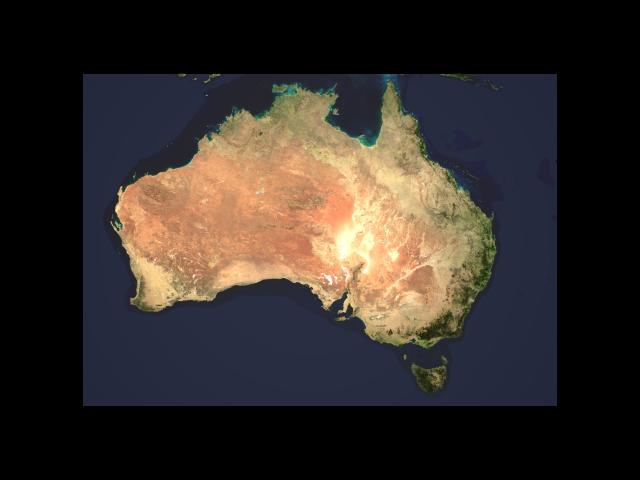

In [61]:
vertical_exaggeration=20
min_lat = -45
max_lat = -10
min_lon = 110
max_lon = 160
cropbox=((min_lat, min_lon), (max_lat, max_lon))
lv = accessvis.plot_region(cropbox=cropbox, vertical_exaggeration=vertical_exaggeration)
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display((640,480))

In [62]:
ds=crop(ds_1_3).sum(dim='time')

In [63]:
ds

<xarray.Dataset> Size: 4kB
Dimensions:   (lat: 29, bnds: 2, lon: 27)
Coordinates:
  * lat       (lat) float64 232B -45.0 -43.75 -42.5 ... -12.5 -11.25 -10.0
  * lon       (lon) float64 216B 110.6 112.5 114.4 116.2 ... 155.6 157.5 159.4
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 464B -45.62 -44.38 -44.38 ... -10.62 -9.375
    lon_bnds  (lon, bnds) float64 432B 109.7 111.6 111.6 ... 158.4 158.4 160.3
    pr        (lat, lon) float32 3kB 0.01638 0.01618 0.01631 ... 0.1307 0.1421

In [64]:
colours = get_interpolated_au(ds['pr'], 'gist_ncar')


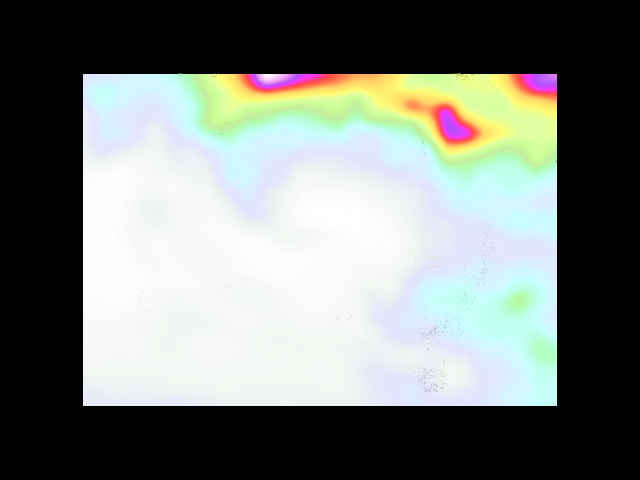

In [65]:
vertical_exaggeration=20
topo = lv.objects['surface']
V = topo.data.vertices_copy[0]

offset = 5 * accessvis.MtoLL * vertical_exaggeration # this converts 5m to lat/lon units, including vertical exaggeration
V[::,::,2] = V[::,::,2] + offset


prsurf = lv.triangles('pr', vertices=V, cullface=True, texture="blank.png", lit=False, opacitymap=True)
prsurf.texture(colours)

lv.display((640,480))